In [95]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append('../src')

import numpy as np
import random
import tensorflow as tf

import matplotlib.pyplot as plt

In [96]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

DEFAULT_COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fm_offset = -0.5

In [97]:
feature_maps = tf.Variable(tf.random.uniform((3, 8, 8, 2048), minval=0, maxval=10))
print(feature_maps.shape)

roi_boxes = tf.Variable(tf.random.uniform((3, 4, 4), minval=0, maxval=8))

x1, y1, x2, y2 = tf.unstack(roi_boxes, axis=-1)
x1, x2 = tf.minimum(x1, x2), tf.maximum(x1, x2)
y1, y2 = tf.minimum(y1, y2), tf.maximum(y1, y2)
roi_boxes = tf.stack([x1, y1, x2, y2], axis=-1)
print(roi_boxes.shape)

(3, 8, 8, 2048)
(3, 4, 4)


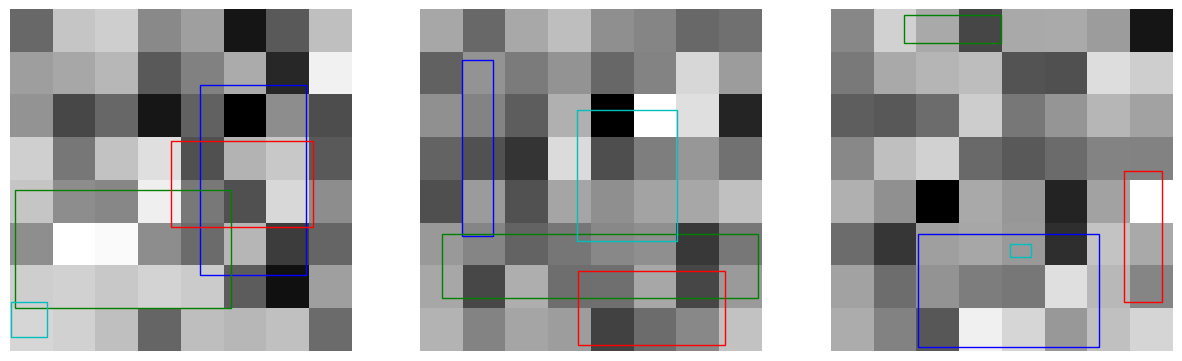

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for batch in range(3):
    axes[batch].imshow(np.mean(feature_maps[batch], axis=-1), cmap='gray')

    for i, roi in enumerate(roi_boxes[batch]):
        x1, y1, x2, y2 = roi
        x1, y1, x2, y2 = x1 + fm_offset, y1 + fm_offset, x2 + fm_offset, y2 + fm_offset
        color = DEFAULT_COLORS[i % len(DEFAULT_COLORS)]

        axes[batch].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))

for ax in axes:
    ax.axis('off')

plt.show()

In [99]:
print(roi_boxes)

tf.Tensor(
[[[4.4433126  1.7703438  6.9193993  6.2182684 ]
  [0.11552811 4.242898   5.1609335  6.9880733 ]
  [3.7577744  3.093831   7.0892315  5.0943136 ]
  [0.01501369 6.862108   0.8630352  7.6804914 ]]

 [[0.967926   1.1935177  1.6910467  5.300149  ]
  [0.5012083  5.2566137  7.896982   6.757041  ]
  [3.6921349  6.12819    7.1199865  7.869047  ]
  [3.6720161  2.3688889  6.007783   5.429879  ]]

 [[2.0533676  5.2676706  6.27271    7.9085827 ]
  [1.7291546  0.14058495 3.9928284  0.78204346]
  [6.8632708  3.777359   7.7500734  6.8535748 ]
  [4.194518   5.501151   4.6796875  5.795802  ]]], shape=(3, 4, 4), dtype=float32)


In [100]:
len_x = roi_boxes[:, :, 2] - roi_boxes[:, :, 0]
len_y = roi_boxes[:, :, 3] - roi_boxes[:, :, 1]

print(len_x)
print(len_y)

tf.Tensor(
[[2.4760866 5.0454054 3.3314571 0.8480215]
 [0.7231207 7.395774  3.4278517 2.3357668]
 [4.219342  2.2636738 0.8868027 0.4851694]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[4.4479246  2.7451754  2.0004826  0.8183832 ]
 [4.1066313  1.5004272  1.7408571  3.0609903 ]
 [2.640912   0.6414585  3.0762157  0.29465103]], shape=(3, 4), dtype=float32)


In [101]:
start_x = roi_boxes[:, :, 0] + len_x / (7 * 4)
start_y = roi_boxes[:, :, 1] + len_y / (7 * 4)

print(start_x)
print(start_y)

tf.Tensor(
[[4.5317445  0.29572117 3.876755   0.04530018]
 [0.99375176 0.76534307 3.814558   3.7554364 ]
 [2.2040584  1.8100001  6.8949423  4.2118454 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[1.9291983  4.34094    3.1652768  6.8913364 ]
 [1.3401831  5.3102     6.1903634  2.47821   ]
 [5.361989   0.16349418 3.887224   5.5116744 ]], shape=(3, 4), dtype=float32)


In [102]:
end_x = roi_boxes[:, :, 2] - len_x / (7 * 4)
end_y = roi_boxes[:, :, 3] - len_y / (7 * 4)

print(end_x)
print(end_y)

tf.Tensor(
[[6.8309674 4.9807405 6.970251  0.8327487]
 [1.665221  7.6328473 6.9975634 5.9243627]
 [6.122019  3.9119828 7.718402  4.66236  ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[6.059414   6.8900313  5.0228677  7.651263  ]
 [5.1534834  6.7034545  7.806874   5.320558  ]
 [7.8142643  0.75913423 6.74371    5.785279  ]], shape=(3, 4), dtype=float32)


In [103]:
sampling_x = tf.linspace(start_x, end_x, 14, axis=-1)
sampling_y = tf.linspace(start_y, end_y, 14, axis=-1)

print(sampling_x)
print(sampling_y)

tf.Tensor(
[[[4.5317445  4.7086077  4.885471   5.0623345  5.2391977  5.416061
   5.592924   5.769788   5.946651   6.123514   6.3003774  6.4772406
   6.654104   6.8309674 ]
  [0.29572117 0.6561073  1.0164933  1.3768795  1.7372656  2.0976517
   2.4580379  2.8184237  3.1788101  3.539196   3.8995824  4.2599683
   4.620354   4.9807405 ]
  [3.876755   4.114716   4.3526773  4.5906386  4.8286     5.066561
   5.3045225  5.5424833  5.780445   6.018406   6.2563677  6.4943285
   6.73229    6.970251  ]
  [0.04530018 0.10587314 0.1664461  0.22701907 0.28759202 0.348165
   0.40873796 0.46931094 0.52988386 0.59045684 0.6510298  0.7116028
   0.7721757  0.8327487 ]]

 [[0.99375176 1.0454032  1.0970547  1.1487062  1.2003577  1.2520092
   1.3036606  1.3553121  1.4069636  1.4586151  1.5102665  1.561918
   1.6135695  1.665221  ]
  [0.76534307 1.2936126  1.8218821  2.3501515  2.8784213  3.4066906
   3.9349604  4.4632297  4.9914994  5.519769   6.0480385  6.576308
   7.1045775  7.6328473 ]
  [3.814558   4.0594

In [104]:
sampling_x = tf.reshape(sampling_x, [3, 4, 14, 1, 1])
sampling_y = tf.reshape(sampling_y, [3, 4, 1, 14, 1])

sampling_x = tf.broadcast_to(sampling_x, [3, 4, 14, 14, 1])
sampling_y = tf.broadcast_to(sampling_y, [3, 4, 14, 14, 1])

sampling_x = tf.reshape(sampling_x, [3, 4, 14 * 14, 1])
sampling_y = tf.reshape(sampling_y, [3, 4, 14 * 14, 1])

sampling_points = tf.concat([sampling_x, sampling_y], axis=-1)

print(sampling_points.shape)
print(sampling_points)

(3, 4, 196, 2)
tf.Tensor(
[[[[4.5317445  1.9291983 ]
   [4.5317445  2.2469072 ]
   [4.5317445  2.5646162 ]
   ...
   [6.8309674  5.423996  ]
   [6.8309674  5.741705  ]
   [6.8309674  6.059414  ]]

  [[0.29572117 4.34094   ]
   [0.29572117 4.537024  ]
   [0.29572117 4.733108  ]
   ...
   [4.9807405  6.497864  ]
   [4.9807405  6.6939473 ]
   [4.9807405  6.8900313 ]]

  [[3.876755   3.1652768 ]
   [3.876755   3.3081684 ]
   [3.876755   3.45106   ]
   ...
   [6.970251   4.7370844 ]
   [6.970251   4.8799763 ]
   [6.970251   5.0228677 ]]

  [[0.04530018 6.8913364 ]
   [0.04530018 6.9497924 ]
   [0.04530018 7.0082483 ]
   ...
   [0.8327487  7.5343513 ]
   [0.8327487  7.5928073 ]
   [0.8327487  7.651263  ]]]


 [[[0.99375176 1.3401831 ]
   [0.99375176 1.6335139 ]
   [0.99375176 1.9268447 ]
   ...
   [1.665221   4.566822  ]
   [1.665221   4.8601527 ]
   [1.665221   5.1534834 ]]

  [[0.76534307 5.3102    ]
   [0.76534307 5.4173737 ]
   [0.76534307 5.524547  ]
   ...
   [7.6328473  6.4891076 ]
  

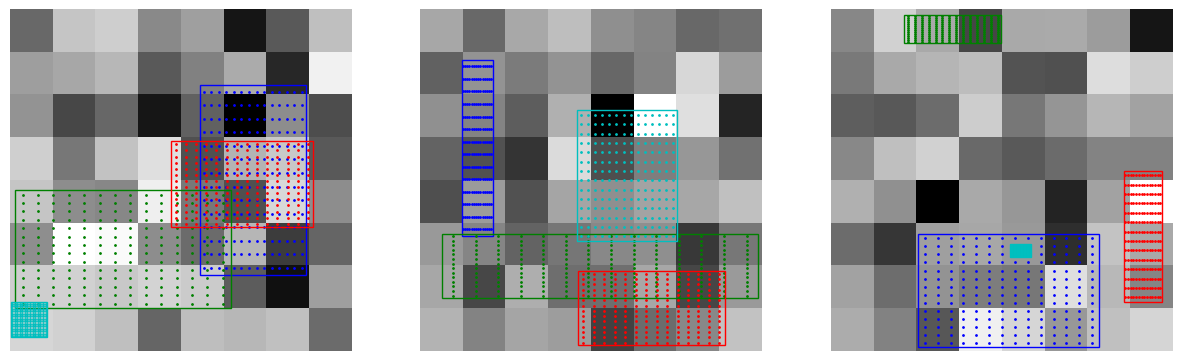

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for batch in range(3):
    axes[batch].imshow(np.mean(feature_maps[batch], axis=-1), cmap='gray')

    for i, roi in enumerate(roi_boxes[batch]):
        x1, y1, x2, y2 = roi
        x1, y1, x2, y2 = x1 + fm_offset, y1 + fm_offset, x2 + fm_offset, y2 + fm_offset
        color = DEFAULT_COLORS[i % len(DEFAULT_COLORS)]

        axes[batch].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))
        axes[batch].scatter(sampling_points[batch, i, :, 0] + fm_offset, sampling_points[batch, i, :, 1] + fm_offset, c=color, s=1)

for ax in axes:
    ax.axis('off')

plt.show()

In [106]:
x_1 = tf.math.floor(sampling_points[..., 0])
y_1 = tf.math.floor(sampling_points[..., 1])
x_2 = tf.math.ceil(sampling_points[..., 0])
y_2 = tf.math.ceil(sampling_points[..., 1])

f_11 = tf.stack([x_1, y_1], axis=-1)
f_12 = tf.stack([x_2, y_1], axis=-1)
f_21 = tf.stack([x_1, y_2], axis=-1)
f_22 = tf.stack([x_2, y_2], axis=-1)

w_11 = (x_2 - sampling_points[..., 0]) * (y_2 - sampling_points[..., 1])
w_12 = (sampling_points[..., 0] - x_1) * (y_2 - sampling_points[..., 1])
w_21 = (x_2 - sampling_points[..., 0]) * (sampling_points[..., 1] - y_1)
w_22 = (sampling_points[..., 0] - x_1) * (sampling_points[..., 1] - y_1)

print(x_1.shape)
print(f_11.shape)
print(w_11.shape)

(3, 4, 196)
(3, 4, 196, 2)
(3, 4, 196)


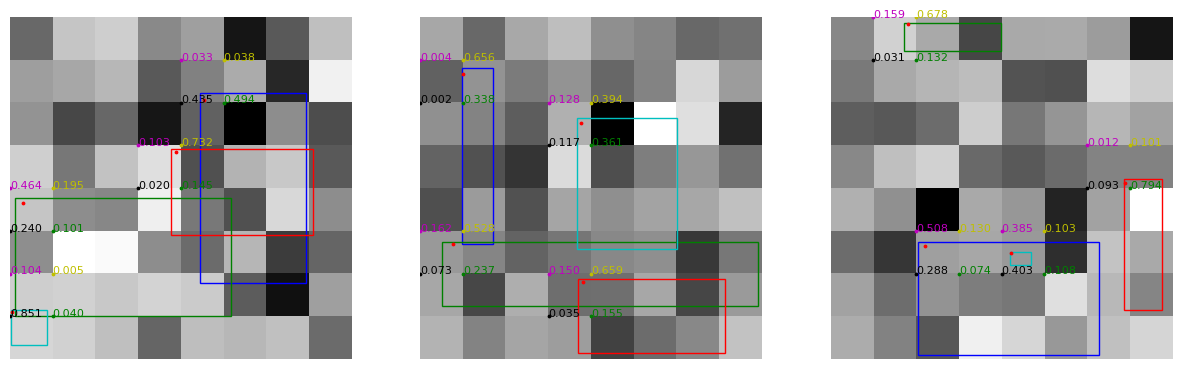

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for batch in range(3):
    axes[batch].imshow(np.mean(feature_maps[batch], axis=-1), cmap='gray')

    for i, roi in enumerate(roi_boxes[batch]):
        x1, y1, x2, y2 = roi
        x1, y1, x2, y2 = x1 + fm_offset, y1 + fm_offset, x2 + fm_offset, y2 + fm_offset
        color = DEFAULT_COLORS[i % len(DEFAULT_COLORS)]

        axes[batch].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, lw=1))
        axes[batch].scatter(sampling_points[batch, i, 0, 0] + fm_offset, sampling_points[batch, i, 0, 1] + fm_offset, c='r', s=3)

        axes[batch].scatter(f_11[batch, i, 0, 0] + fm_offset, f_11[batch, i, 0, 1] + fm_offset, c='m', s=3)
        axes[batch].scatter(f_12[batch, i, 0, 0] + fm_offset, f_12[batch, i, 0, 1] + fm_offset, c='y', s=3)
        axes[batch].scatter(f_21[batch, i, 0, 0] + fm_offset, f_21[batch, i, 0, 1] + fm_offset, c='k', s=3)
        axes[batch].scatter(f_22[batch, i, 0, 0] + fm_offset, f_22[batch, i, 0, 1] + fm_offset, c='g', s=3)

        axes[batch].text(f_11[batch, i, 0, 0] + fm_offset, f_11[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_11[batch, i, 0]), color='m', fontsize=8)
        axes[batch].text(f_12[batch, i, 0, 0] + fm_offset, f_12[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_12[batch, i, 0]), color='y', fontsize=8)
        axes[batch].text(f_21[batch, i, 0, 0] + fm_offset, f_21[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_21[batch, i, 0]), color='k', fontsize=8)
        axes[batch].text(f_22[batch, i, 0, 0] + fm_offset, f_22[batch, i, 0, 1] + fm_offset, '{:.3f}'.format(w_22[batch, i, 0]), color='g', fontsize=8)

for ax in axes:
    ax.axis('off')

plt.show()